# Chicago Crime Statistics

## Data

### Chicago Crime [Source: https://www.kaggle.com/currie32/crimes-in-chicago/data]
Crimes in Chicago from 2001 to 2017 (1.85GB)

This data is broken up into 4 files:<br>
Chicago_Crimes_2001_to_2004.csv<br>
Chicago_Crimes_2005_to_2007.csv<br>
Chicago_Crimes_2008_to_2011.csv<br>
Chicago_Crimes_2012_to_2017.csv<br>

### Community Areas [Source: https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6]
Fairly small csv (CommAreas.csv), provides Name of the community that can be tied back to Chicago Crimes csvs. 


In [9]:
from pyspark.sql import functions as func
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt
import pandas

def print_cols_types(df):
    print("Columns:")
    for f in df.schema.fields:
        print("%s (%s)" % (f.name, f.dataType))
    print('+--------------------------------+')
    
areas_df = sqlContext.read.load("hdfs://sandbox.hortonworks.com:8020/bigdata1_final_project/CommAreas.csv",
                        format='com.databricks.spark.csv',
                        header='true',
                        inferSchema=True)
print_cols_types(areas_df)


crime_df = sqlContext.read.load("hdfs://sandbox.hortonworks.com:8020/bigdata1_final_project/Chicago_Crimes_*.csv",
                        format='com.databricks.spark.csv',
                        header='true',
                        inferSchema=True)
print_cols_types(crime_df)

Columns:
the_geom (StringType)
PERIMETER (IntegerType)
AREA (IntegerType)
COMAREA_ (IntegerType)
COMAREA_ID (IntegerType)
AREA_NUMBE (IntegerType)
COMMUNITY (StringType)
AREA_NUM_1 (IntegerType)
SHAPE_AREA (DoubleType)
SHAPE_LEN (DoubleType)
+--------------------------------+
Columns:
_c0 (IntegerType)
ID (IntegerType)
Case Number (StringType)
Date (StringType)
Block (StringType)
IUCR (StringType)
Primary Type (StringType)
Description (StringType)
Location Description (StringType)
Arrest (StringType)
Domestic (StringType)
Beat (StringType)
District (StringType)
Ward (StringType)
Community Area (StringType)
FBI Code (StringType)
X Coordinate (StringType)
Y Coordinate (StringType)
Year (StringType)
Updated On (StringType)
Latitude (StringType)
Longitude (StringType)
Location (StringType)
+--------------------------------+


# Clean Up
### Clean up Primary Type Column
Some of the Primary Types had similar names that can be combined into one Primary Type.

In [10]:
def clean_primary_types(val):
    """UDF function to fix duplicate primary types"""
    if val in ("NON - CRIMINAL", "NON-CRIMINAL", "NON-CRIMINAL (SUBJECT SPECIFIED)"):
        return "NON-CRIMINAL"
    if "NARCOTIC" in val:
        return "NARCOTICS"
    return val


# Show current Primary Types
crime_df.select("Primary Type").distinct().sort("Primary Type").show(200, False)

clean_primary_types_udf = func.udf(clean_primary_types, StringType())
crime_df = crime_df.withColumn("Primary Type", clean_primary_types_udf(crime_df["Primary Type"]))

# Show cleaned Primary Types
crime_df.select("Primary Type").distinct().sort("Primary Type").show(200, False)


+---------------------------------+
|Primary Type                     |
+---------------------------------+
|ARSON                            |
|ASSAULT                          |
|BATTERY                          |
|BURGLARY                         |
|CONCEALED CARRY LICENSE VIOLATION|
|CRIM SEXUAL ASSAULT              |
|CRIMINAL DAMAGE                  |
|CRIMINAL TRESPASS                |
|DECEPTIVE PRACTICE               |
|DOMESTIC VIOLENCE                |
|GAMBLING                         |
|HOMICIDE                         |
|HUMAN TRAFFICKING                |
|INTERFERENCE WITH PUBLIC OFFICER |
|INTIMIDATION                     |
|IUCR                             |
|KIDNAPPING                       |
|LIQUOR LAW VIOLATION             |
|MOTOR VEHICLE THEFT              |
|NARCOTICS                        |
|NON - CRIMINAL                   |
|NON-CRIMINAL                     |
|NON-CRIMINAL (SUBJECT SPECIFIED) |
|OBSCENITY                        |
|OFFENSE INVOLVING CHILDREN 

### Clean up District Column


In [11]:
crime_df.select("District").distinct().sort("District").show(200, False)

# integer cast will return null for string values like Beat
crime_df = crime_df.withColumn("District", crime_df["District"].cast("integer"))
# now remove any nulls
crime_df = crime_df.filter(crime_df["District"].isNotNull())

crime_df.select("District").distinct().sort("District").show(200, False)


+--------+
|District|
+--------+
|null    |
|1.0     |
|10.0    |
|11.0    |
|12.0    |
|13.0    |
|14.0    |
|15.0    |
|16.0    |
|17.0    |
|18.0    |
|19.0    |
|2.0     |
|20.0    |
|21.0    |
|22.0    |
|23.0    |
|24.0    |
|25.0    |
|3.0     |
|31.0    |
|4.0     |
|5.0     |
|6.0     |
|7.0     |
|8.0     |
|9.0     |
|Beat    |
+--------+

+--------+
|District|
+--------+
|1       |
|2       |
|3       |
|4       |
|5       |
|6       |
|7       |
|8       |
|9       |
|10      |
|11      |
|12      |
|13      |
|14      |
|15      |
|16      |
|17      |
|18      |
|19      |
|20      |
|21      |
|22      |
|23      |
|24      |
|25      |
|31      |
+--------+



### Clean up Year Column

There were some bad rows that did not contain valid years.
I also chose to remove data for 2017 as it was incomplete and ended up being outliner in all of the analysis.


In [12]:
crime_df.select("Year").distinct().show()

# clean
valid_years = list(range(2002, 2017))  # 2002 to 2016
crime_df = crime_df.filter(crime_df.Year.isin(valid_years))

print("Done cleaning year data...")

crime_df.select("Year").distinct().show()


+------------+
|        Year|
+------------+
|        2016|
|        2012|
|        2017|
|        2014|
|        2013|
|        2005|
|        2002|
|        2009|
|        2006|
|        2004|
|        2011|
|        2008|
|        2007|
|41.789832136|
|        2015|
|        2001|
|        2010|
|        2003|
+------------+

Done cleaning year data...
+----+
|Year|
+----+
|2016|
|2012|
|2014|
|2013|
|2005|
|2002|
|2009|
|2006|
|2004|
|2011|
|2008|
|2007|
|2015|
|2010|
|2003|
+----+



### Join Community Areas

In [13]:
areas_df = areas_df.select(areas_df["AREA_NUM_1"].alias("Community Area"), 
                           areas_df["COMMUNITY"].alias("Community Description"))

crime_df = crime_df.join(areas_df, "Community Area")
crime_df.show(1)

+--------------+---+-------+-----------+--------------------+-----------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------+------------+------------+----+--------------------+--------+---------+--------+---------------------+
|Community Area|_c0|     ID|Case Number|                Date|            Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|Latitude|Longitude|Location|Community Description|
+--------------+---+-------+-----------+--------------------+-----------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------+------------+------------+----+--------------------+--------+---------+--------+---------------------+
|          46.0|879|4786321|   HM399414|01/01/2004 12:01:...|082XX S COLES AVE|0840|       THEFT|FINANCIAL ID THEF...|           RESIDENCE| Fa

### Are there duplicates?
Check for any duplicate rows, and drop if any.

In [21]:
# print(crime_df.count()) => 7227632
# print(crime_df.dropDuplicates().count()) => 5543285

7227632
5543285


In [14]:
# print(crime_df.rdd.getNumPartitions())
# crime_df = crime_df.dropDuplicates()
# print(crime_df.rdd.getNumPartitions())

# crime_df = crime_df.coalesce(16)
# print(crime_df.rdd.getNumPartitions())


16
200
16


# Location Analysis

## Unique Crime Location Descriptions
After grouping crime by location descriptions, I selected records with a count of one.
These are the ones I defined as "unique locations".

In [7]:
# Group by location descriptions
location_all_counts_df = crime_df.groupBy("Location Description").count()
# Filter to locations that only appear once
single_occurance_crime_df = location_all_counts_df.filter("count == 1")
# Use flat map to get a simple list
locations = single_occurance_crime_df.select("Location Description").rdd.flatMap(lambda x:x).collect()
# Rename column to remove space, to get it working with isin() method and filter to get only uniq locations
col_renamed_df = crime_df.withColumnRenamed("Location Description", "LocationDescription")
filtered_df = col_renamed_df.filter(col_renamed_df.LocationDescription.isin(locations))

print("*** Most Unique Crime Locations ***")
filtered_df.select(
    "LocationDescription", "Primary Type", "Date", "Case Number").show(50, False)


*** Most Unique Crime Locations ***
+----------------------+------------+----------------------+-----------+
|LocationDescription   |Primary Type|Date                  |Case Number|
+----------------------+------------+----------------------+-----------+
|PUBLIC GRAMMAR SCHOOL |HOMICIDE    |07/09/2002 11:55:00 PM|HH499180   |
|JUNK YARD/GARBAGE DUMP|HOMICIDE    |08/01/2002 04:15:00 AM|HH549811   |
|FUNERAL PARLOR        |HOMICIDE    |11/13/2002 07:25:00 PM|HH777608   |
|TRUCKING TERMINAL     |HOMICIDE    |08/14/2003 09:10:00 AM|HJ561015   |
|YMCA                  |HOMICIDE    |05/22/2005 01:40:00 PM|HL371794   |
|COACH HOUSE           |HOMICIDE    |06/04/2006 04:10:00 PM|HM393124   |
|LIVERY AUTO           |HOMICIDE    |10/05/2006 04:50:00 AM|HM641124   |
|BANQUET HALL          |HOMICIDE    |09/23/2007 01:23:00 AM|HN605728   |
|ROOMING HOUSE         |HOMICIDE    |01/24/2009 02:26:00 AM|HR136031   |
|ELEVATOR              |HOMICIDE    |01/29/2016 06:43:00 PM|HZ126483   |
|CLEANERS/LAUND

## Top 10 Most Common Crime Location Descriptions

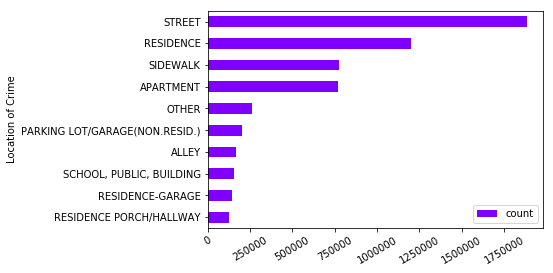

In [27]:
location_counts_sorted_df = location_all_counts_df.sort("count", ascending=False).limit(10)

pdf = location_counts_sorted_df.toPandas()
pdf = pdf.sort_values(by="count", ascending=True)
pdf.plot(kind='barh', x='Location Description', y='count', colormap='rainbow')
plt.ylabel('Location of Crime')
plt.xticks(rotation=30)
plt.show()

# Year Analysis

## Homicides Per Year
http://www.newsweek.com/2016/12/23/chicago-gangs-violence-murder-rate-532034.html

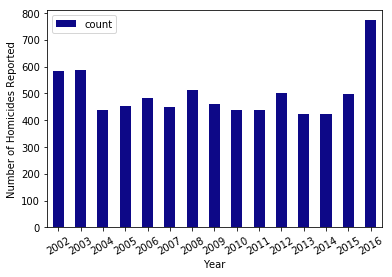

In [28]:
homicide_per_year_df = crime_df.filter(crime_df["Primary Type"] == 'HOMICIDE').groupBy("Year").count().sort(
    "Year", ascending=True)

pdf = homicide_per_year_df.toPandas()
pdf.plot(kind='bar', x='Year', y='count', colormap='plasma')
plt.ylabel('Number of Homicides Reported')
plt.xticks(rotation=30)
plt.show()

## Crimes Per Year
Shows number of crimes reported by year.

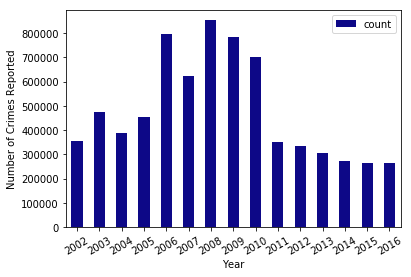

In [29]:
crime_per_year_df = crime_df.groupBy("Year").count().sort("Year")

pdf = crime_per_year_df.toPandas()
pdf.plot(kind='bar', x='Year', y='count', colormap='plasma')
plt.ylabel('Number of Crimes Reported')
plt.xticks(rotation=30)
plt.show()

# Arrests Per Year
Shows number of actual arrests made by year. Not every crime reported resulted in an arrest. Sorted by years with highest arrest number.

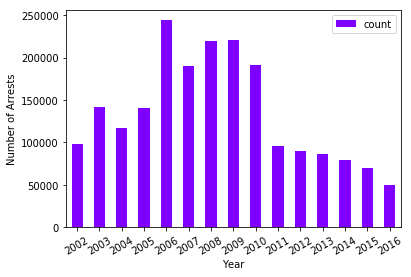

In [30]:
arrests_per_year_df = crime_df.where(crime_df.Arrest == "True").groupBy("Year").count().sort("Year")

pdf = arrests_per_year_df.toPandas()
pdf.plot(kind='bar', x='Year', y='count', colormap='rainbow')
plt.ylabel('Number of Arrests')
plt.xticks(rotation=30)
plt.show()


# Crime to Arrest Ratio
Calculate ratio of actual arrests from reported crime.
Create two separate data frames containing year and counts, one with all crimes (all rows) and second with rows that have Arrest => true.

In [31]:
# Collect Year and Count with crimes that had arrests
arrests_only_df = crime_df.where(crime_df.Arrest == "True")
arrests_only_df = arrests_only_df.groupBy("Year").agg(
    func.count(arrests_only_df.ID).alias("arrest_count")) 

# Collect Year and Count with all crimes
all_crime_df = crime_df.groupBy("Year").agg(
    func.count(crime_df.ID).alias("crime_count")) 

# Join arrests only and all crime stats counts into one "table"
joined_df = all_crime_df.join(arrests_only_df, "Year")

# Get ratio
print("*** Arrest Ratio per Year ***")
ratio_df = joined_df.select(joined_df.Year, (
    (joined_df.arrest_count / joined_df.crime_count) * 100).cast("integer").alias("arrest_ratio")
)
ratio_df.show()


*** Arrest Ratio per Year ***
+----+------------+
|Year|arrest_ratio|
+----+------------+
|2016|          18|
|2012|          26|
|2014|          28|
|2013|          28|
|2005|          30|
|2002|          27|
|2009|          28|
|2006|          30|
|2004|          30|
|2011|          27|
|2008|          25|
|2007|          30|
|2015|          26|
|2010|          27|
|2003|          29|
+----+------------+



info online discussing arrests precentages significantly down in recent years (2016, 2017)
https://chicago.suntimes.com/chicago-politics/the-watchdogs-arrests-down-25-percent-in-chicago-this-year/
https://www.google.com/search?q=chicago+arrests+down+in+2016&oq=chicago+arrests+down+in+2016&aqs=chrome..69i57.5702j0j4&sourceid=chrome&ie=UTF-8

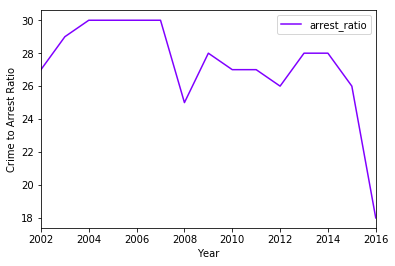

In [32]:
pdf = ratio_df.sort("Year").toPandas()
pdf.plot(kind='line', x='Year', y='arrest_ratio', colormap='rainbow')
plt.ylabel('Crime to Arrest Ratio')
plt.show()

# Top Crimes per Year

In [33]:
year_max_cnt_df = crime_df.groupBy("Year", "Primary Type").count().groupBy("Year").agg(
    func.max("count").alias("count"))
year_type_count_df = crime_df.groupBy("Year", "Primary Type").count()
year_type_count_df.join(year_max_cnt_df, ["count", "Year"]).sort("Year").show()

+------+----+------------+
| count|Year|Primary Type|
+------+----+------------+
| 73820|2002|       THEFT|
| 99057|2003|       THEFT|
| 81358|2004|       THEFT|
| 86392|2005|       THEFT|
|152265|2006|       THEFT|
|118801|2007|       THEFT|
|176478|2008|       THEFT|
|161693|2009|       THEFT|
|144312|2010|       THEFT|
| 75205|2011|       THEFT|
| 75447|2012|       THEFT|
| 71523|2013|       THEFT|
| 61529|2014|       THEFT|
| 57292|2015|       THEFT|
| 61167|2016|       THEFT|
+------+----+------------+



# Least Crimes per Year

In [34]:
year_max_cnt_df = crime_df.groupBy("Year", "Primary Type").count().groupBy("Year").agg(
    func.min("count").alias("count"))
year_type_count_df = crime_df.groupBy("Year", "Primary Type").count()
year_type_count_df.join(year_max_cnt_df, ["count", "Year"]).sort("Year").show()

+-----+----+-----------------+
|count|Year|     Primary Type|
+-----+----+-----------------+
|    2|2002|        RITUALISM|
|    1|2003|     NON-CRIMINAL|
|    1|2003|        RITUALISM|
|    1|2004|        RITUALISM|
|    3|2005|        RITUALISM|
|    8|2006| PUBLIC INDECENCY|
|    1|2007|        RITUALISM|
|    8|2008| PUBLIC INDECENCY|
|    1|2009|     NON-CRIMINAL|
|    2|2010|     NON-CRIMINAL|
|   13|2011| PUBLIC INDECENCY|
|    8|2012|     NON-CRIMINAL|
|    2|2013|HUMAN TRAFFICKING|
|    2|2014|HUMAN TRAFFICKING|
|   13|2015|HUMAN TRAFFICKING|
|   10|2016| PUBLIC INDECENCY|
+-----+----+-----------------+



# Top 10 Crimes
Top 10 crimes, all years.
Collect count of each crime type per year, then take an average of counts to get top 10 crimes.

In [35]:
temp_df = crime_df.groupBy("Year", "Primary Type").count().groupBy("Primary Type").agg(
    func.avg("count").cast("integer").alias("Avg Count"))
temp_df.sort("Avg Count", ascending=False).limit(10).show()

+-------------------+---------+
|       Primary Type|Avg Count|
+-------------------+---------+
|              THEFT|    99755|
|            BATTERY|    87061|
|    CRIMINAL DAMAGE|    56011|
|          NARCOTICS|    53853|
|      OTHER OFFENSE|    29666|
|            ASSAULT|    29033|
|           BURGLARY|    28881|
|MOTOR VEHICLE THEFT|    22103|
|            ROBBERY|    18220|
| DECEPTIVE PRACTICE|    17294|
+-------------------+---------+



# Top 10 Crimes with Arrests
Top 10 crimes, all years that resulted in arrests.
Collect count of each crime type per year that had Arrests=True, then take an average of counts to get top 10 crimes.

In [37]:
temp_df = crime_df.where(crime_df.Arrest == "True").groupBy("Year", "Primary Type").count().groupBy("Primary Type").agg(
    func.avg("count").cast("integer").alias("Avg Count"))
temp_df.sort("Avg Count", ascending=False).limit(10).show()

+------------------+---------+
|      Primary Type|Avg Count|
+------------------+---------+
|         NARCOTICS|    53391|
|           BATTERY|    19973|
|             THEFT|    11561|
| CRIMINAL TRESPASS|    10136|
|           ASSAULT|     6886|
|      PROSTITUTION|     5127|
|     OTHER OFFENSE|     5010|
|   CRIMINAL DAMAGE|     3908|
| WEAPONS VIOLATION|     3779|
|DECEPTIVE PRACTICE|     3053|
+------------------+---------+



## Most Dangerous / Safest Hour

Calculates counts of crimes per date, then take an average of those counts to determine safest / most dangerous hour.


In [38]:
date_format = "MM/dd/yyyy hh:mm:ss a"

by_hour_df = crime_df.select(
    func.date_format(func.unix_timestamp(crime_df.Date, date_format
        ).cast("timestamp"), "MM/dd/yyyy").alias("JustDate"), 
    func.date_format(func.unix_timestamp(crime_df.Date, date_format
        ).cast("timestamp"), "HH").alias("JustHour")
    ).groupBy("JustDate", "JustHour").count().groupBy("JustHour").agg(
        func.avg("count").cast("integer").alias("AvgCount")).sort("AvgCount", ascending=False)
by_hour_df.show(24, False)

+--------+--------+
|JustHour|AvgCount|
+--------+--------+
|00      |75      |
|20      |75      |
|19      |75      |
|21      |74      |
|12      |74      |
|22      |73      |
|18      |71      |
|15      |70      |
|17      |66      |
|14      |66      |
|16      |65      |
|13      |62      |
|23      |60      |
|11      |58      |
|09      |56      |
|10      |55      |
|08      |44      |
|01      |42      |
|02      |35      |
|07      |30      |
|03      |28      |
|06      |21      |
|04      |21      |
|05      |17      |
+--------+--------+



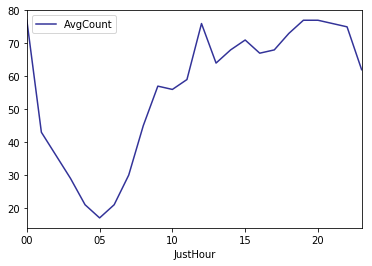

In [46]:
pdf = by_hour_df.sort("JustHour").toPandas()
pdf.plot(kind='line', x='JustHour', y='AvgCount', colormap='terrain')
plt.show()

## Time of Day to Crime Rates (Homicide, Burglary, Arson, Theft)

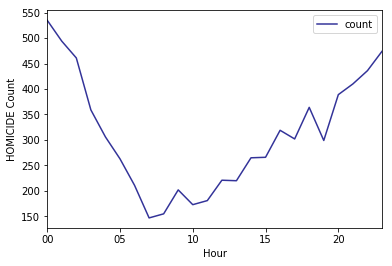

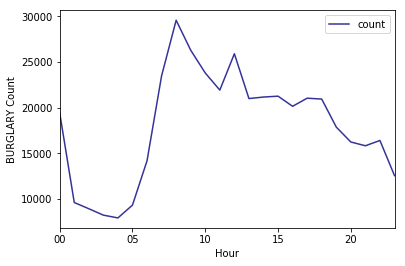

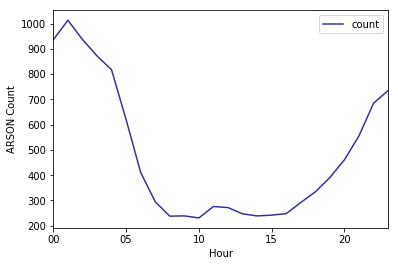

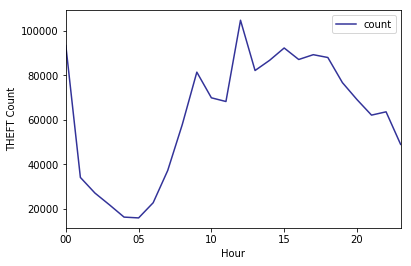

In [14]:
date_format = "MM/dd/yyyy hh:mm:ss a"

for pri_type in ("HOMICIDE", "BURGLARY", "ARSON", "THEFT"):
    hour_counts_df = crime_df.filter(crime_df["Primary Type"] == pri_type).select(
            func.date_format(func.unix_timestamp(crime_df.Date, date_format
        ).cast("timestamp"), "HH").alias("Hour")).groupBy("Hour").count()
    pdf = hour_counts_df.sort("Hour").toPandas()
    pdf.plot(kind='line', x='Hour', y='count', colormap='terrain')
    plt.ylabel('%s Count' % pri_type)
    plt.show()

# Crimes by Districts / Community

http://gis.chicagopolice.org/website/ClearMap/viewer.htm?POLICEDIST=011

<img src="http://chronicle.uchicago.edu/991104/map.gif">
<img src="https://home.chicagopolice.org/wp-content/uploads/2014/11/communitymap_preview.png">


In [15]:
by_district_df = crime_df.groupBy(crime_df["District"]).agg(
    func.count(crime_df.ID).alias("count"), func.collect_set(crime_df["Community Description"]).alias("communities"))
by_district_df.show(1, False)

# From output we can see that communities don't map correctly to districts; don't use it.

print("*** Top 5 Low Crime Districts ***")
by_district_df.sort("count").select(crime_df["District"].cast("integer"), "count").limit(5).show(10, False)

print("*** Top 10 High Crime Districts ***")
by_district_df.sort("count", ascending=False).select(
    crime_df["District"].cast("integer"), "count").limit(10).show(10, False)

+--------+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|District|count|communities                                                                                                                                                                                                                                                                                                                                                                                                                                 |
+--------+-----+--------------------------------------------------------------------------------------------

In [16]:
homicide_by_district_df = crime_df.filter(
    crime_df["Primary Type"] == "HOMICIDE").groupBy(crime_df["District"]).count()

print("*** Top 5 Low Homicide Districts ***")
homicide_by_district_df.sort("count").select(crime_df["District"].cast("integer"), "count").limit(5).show()

print("*** Top 10 High Homicide Districts ***")
homicide_by_district_df.sort("count", ascending=False).select(
    crime_df["District"].cast("integer"), "count").limit(10).show()

*** Top 5 Low Homicide Districts ***
+--------+-----+
|District|count|
+--------+-----+
|      20|   54|
|      16|   65|
|       1|   67|
|      18|   83|
|      19|  113|
+--------+-----+

*** Top 10 High Homicide Districts ***
+--------+-----+
|District|count|
+--------+-----+
|      11|  724|
|       7|  710|
|       6|  559|
|      10|  522|
|       4|  511|
|       9|  493|
|       8|  489|
|       3|  488|
|       5|  461|
|      15|  426|
+--------+-----+



https://www.themarshallproject.org/2016/09/20/the-most-dangerous-neighborhood-the-most-inexperienced-cops
<blockquote>
The officers who patrol the Chicago’s 11th Police District face a daunting challenge. The district, which is centered around Garfield Park on the city’s West Side, has the highest murder rate in the city, and it’s rising fast.
</blockquote>

### Community areas with Most / Least Homicides

In [18]:
homicide_by_comm_desrc_df = crime_df.filter(
    crime_df["Primary Type"] == "HOMICIDE").groupBy(crime_df["Community Description"]).count()

print("*** Top 3 Low Homicide Community ***")
homicide_by_comm_desrc_df.sort("count").limit(3).show()

print("*** Top 3 High Homicide Community ***")
homicide_by_comm_desrc_df.sort("count", ascending=False).limit(5).show()

*** Top 3 Low Homicide Community ***
+---------------------+-----+
|Community Description|count|
+---------------------+-----+
|          EDISON PARK|    1|
|      MOUNT GREENWOOD|    2|
|          FOREST GLEN|    4|
+---------------------+-----+

*** Top 3 High Homicide Community ***
+---------------------+-----+
|Community Description|count|
+---------------------+-----+
|               AUSTIN|  606|
|       WEST ENGLEWOOD|  350|
|            ENGLEWOOD|  336|
|        HUMBOLDT PARK|  330|
|       NORTH LAWNDALE|  307|
+---------------------+-----+

